# Adult Census Data Set

Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset was donated to the UCI ML Repository in 1996. 

It is a classification task to predict if an individual wil earn an annual salary of >50K or <=50K

In [1]:
from __future__ import print_function, absolute_import, division
import os
import tempfile
import shutil
import sys
from typing import Tuple

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
print(f'Running TensorFlow version {tf.__version__} with Python {sys.version}')

Running TensorFlow version 1.9.0 with Python 3.6.5 (default, Jun 17 2018, 12:13:06) 
[GCC 4.2.1 Compatible Apple LLVM 9.1.0 (clang-902.0.39.2)]


## Read the U.S. Census Data

We'll be using the U.S. Census Income Dataset from 1994 and 1995 from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/adult)

The problem is to predict one of two labels from the data and is commonly known as a binary classification problem. These two labels are whether each individual (row of data) has an annual income of over 50K or less than 50K.

Getting data is always the first problem in machine learning. In this case we're going to download a comma separated value (CSV) file. This is basically an Excel datasheet if you've ever double clicked a file like this on your computer. It is a very common format to distribute data and has one example per row with each feature or column separated by a comma.

### Download

In [31]:
def retrieve_data(cache_subdirectory: str='/tmp/datasets/census') -> Tuple[str, str]:
  """Download the census dataset to local directory
  
  Args:
    cache_subdirectory: Local directory to cache downloads
  
  Returns:
    Tuple of local paths of (train, test)
  """

  remote_files = [
      'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', 
      'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
  ]

  for file in remote_files:
      local_fname = os.path.basename(file)

      tf.keras.utils.get_file(local_fname, origin=file, cache_subdir=cache_subdirectory)

      yield os.path.join(cache_subdirectory, local_fname)

In [32]:
# Set up the full path of the csv files on disk
train_local_file, test_local_file = retrieve_data()

### Inspect

The [dataset page](https://archive.ics.uci.edu/ml/datasets/adult) lists attribute information about the dataset which is copied into the table below.

| Column | Feature Description |
| -------|---------------------|
| age | continuous. |
| workclass | Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. |
| fnlwgt | continuous (the # people census takers believe that observation represents) |
| education | Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. |
| education-num | continuous (education feature in numerical form) |
| marital-status | Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. |
| occupation | Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. |
| relationship | Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. |
| race | White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. |
| sex | Female, Male. |
| capital-gain | continuous. |
| capital-loss | continuous. |
| hours-per-week | continuous. |
| native-country | United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands. |

The csv files don't have a header to label the columns so we list them out here for use in the pandas dataframe in the variable `CSV_COLUMNS`. We are also defining the column we want to predict as the `LABEL_KEY`.

In [33]:
CSV_COLUMNS = [
    'age', 'workclass', 'fnl', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
    'hours-per-week', 'native-country', 'income-bracket'
]

LABEL_KEY = 'income-bracket'

Notebooks allow us to call `bash` functions inline by use of an exclamation mark at the start of the call. Before we start loading the data, we are going to use the bash `head` command to read and display the first few lines of our dataset file. This can be useful to get a bit of an understanding of how the dataset is formatted so we can read it in appropriately

In [34]:
!head -n 3 {train_local_file}

39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, <=50K
50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 13, United-States, <=50K
38, Private, 215646, HS-grad, 9, Divorced, Handlers-cleaners, Not-in-family, White, Male, 0, 0, 40, United-States, <=50K


In [35]:
!head -n 3 {test_local_file}

|1x3 Cross validator
25, Private, 226802, 11th, 7, Never-married, Machine-op-inspct, Own-child, Black, Male, 0, 0, 40, United-States, <=50K.
38, Private, 89814, HS-grad, 9, Married-civ-spouse, Farming-fishing, Husband, White, Male, 0, 0, 50, United-States, <=50K.


Viewing the dataset above, we can notice a few things:
* Fields are separated by a command and space i.e. ', '
* The test file has a description on the first line that isn't part of the data
* The labels in the test file have a period whereas the labels in the train file do not

We will have to use these few bits of information to just do a few transforms when loading the data so we have a clean and consistent dataset.

We would normally have to consider how we deal with rows that have missing values. To keep things simple, in this case, we are just going to drop any rows that aren't complete.

### Load

Load up the training data into a dataframe using our separator and column names

In [36]:
train_df = pd.read_csv(train_local_file, index_col=None, sep=', ', 
                       header=None, engine='python', names=CSV_COLUMNS)

# Drop rows with missing values
train_df.dropna(inplace=True)

Load up the test data into a dataframe using our separator, column names and drop the period from the label column

In [37]:
test_df = pd.read_csv(test_local_file, index_col=None, sep=', ', 
                      header=1, engine='python', names=CSV_COLUMNS)

# Test dataset has periods on the end of the labels we'll drop off to match the train set
test_df['income-bracket'] = test_df['income-bracket'].apply(lambda val: val[:-1])

# Drop rows with missing values
test_df.dropna(inplace=True)

Similar to our use of the bash `head` command previously, we can now visualise the first few rows of our dataframe by using the `head()` function provided by pandas

In [38]:
train_df.head(3)

,age,workclass,fnl,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


Visualising the distribution of the dataset can also be useful to give some intuition about the problem. It can also provide some insights into what features may be useful as predictors.

You can also see the large distribution that values can take within a feature. In machine learning this can pose problems as the relative weighting of the number 1 to 1,000 to 1,000,000 can be troublesome for the optimiser to learn appropriate weights. To handle this, we can normalise a feature by scaling it by subtracting the average and dividing by the standard deviation of that feature.

To keep things simple here we will ignore values that don't have a simple distribution or are extremely skewed.

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13155a1d0>,
      dtype=object)

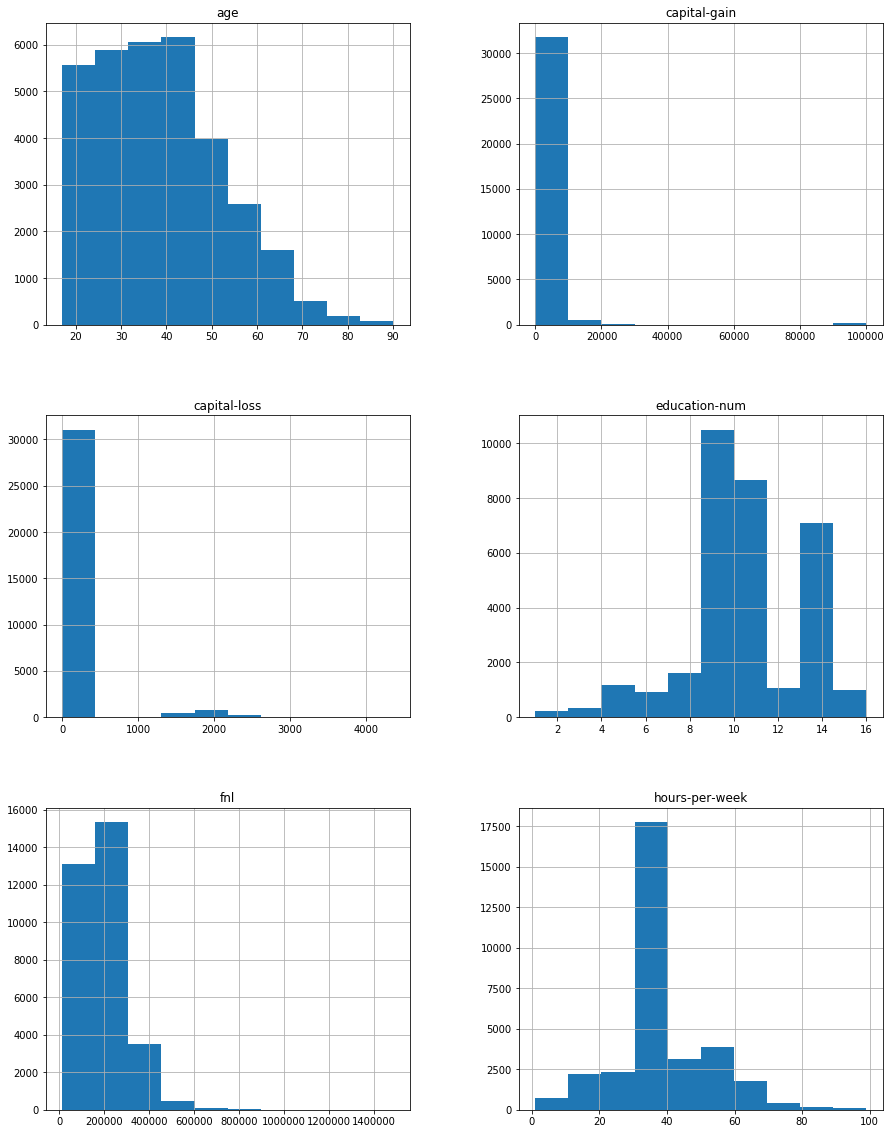

In [39]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
train_df.hist(ax=ax)

In [40]:
test_df.head(3)

,age,workclass,fnl,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-bracket
0,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
1,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
2,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K


### Feature Columns

We have both numeric and categorical data but the model only knows how to deal with numbers.

Categorical features is a feature that can be one of a limited number of possible values. As an example, in this dataset, the 'sex' column is either Male or Female. To use this type of feature in our model, we will have to transform it in some way so it becomes a number which we'll show below.

The other types of features are natively numeric and their magnitude has some meaning. We will define the list of numeric and categorical feature columns by their names so we can appropriately transform each before being used in our model.

In [42]:
NUMERIC_FEATURE_KEYS = [
    'age', 'hours-per-week'
]

CATEGORICAL_FEATURE_KEYS = [
    'workclass', 'education', 'marital-status', 'occupation', 'relationship',
    'race', 'sex', 'native-country'
]

It is also handy to know the unique list of values a column can have (especially the labels). Here we'll just grab the unique list of labels which we expect to be `['<=50K', '>50K']`

In [ ]:
LABEL_VOCAB = list(train_df['income-bracket'].unique())

### TensorFlow Data

TensorFlow wants to have a function it can call each time it wants more data. Here we'll use built in utilities that create functions from our pandas dataframes.

In [44]:
train_x = train_df.drop(LABEL_KEY, axis=1)
train_y = train_df[LABEL_KEY]
train_input_fn = tf.estimator.inputs.pandas_input_fn(x=train_x, y=train_y, shuffle=True, num_epochs=None, batch_size=1024)

test_x = test_df.drop(LABEL_KEY, axis=1)
test_y = test_df[LABEL_KEY]
test_input_fn = tf.estimator.inputs.pandas_input_fn(x=test_x, y=test_y, shuffle=False, num_epochs=None, batch_size=1)

As we mentioned above, numeric and categorical columns need to be fed differently into our model.

Firstly we'll just map our numeric data columns to TensorFlow feature columns directly (n.b. there is many more interesting ways that these columns could be used: look at [normalisation](https://en.wikipedia.org/wiki/Feature_scaling), [bucketized columns](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column) and others

In [48]:
real_valued_columns = [tf.feature_column.numeric_column(key, shape=()) 
                       for key in NUMERIC_FEATURE_KEYS]

Next we'll look at the categorical columns: the simplest method is to 'One-Hot-Encode' the data. 

The method has a list of zeroes for each feature with the same length as the number of categories. A one is set for the column indicating the matched category. An example looking at countries:

If our country list = 'Australia', 'England', 'Canada', 'New Zealand'

If our row of data has 'Australia' then our one-hot encoded values are `[1, 0, 0, 0]` 

'Canada' -> `[0, 0, 1, 0]`

'England' -> `[0, 1, 0, 0]`

'New Zealand' -> `[0, 0, 0, 1]`

TensorFlow provides a utility function for this and the code below will create all the transforms from our categorical features to one-hot columns for each

In [48]:
categorical_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            key, train_df[key].unique()))
    for key in CATEGORICAL_FEATURE_KEYS
]

Finally just create a list of inputs that has both our numeric and categorical columns

In [48]:
INPUT_COLUMNS = real_valued_columns + categorical_columns

## Linear Model

Although deep neural networks are generating a lot of amazing results, they are computationally expensive compared to a linear model. We start with the simplest model we can to:
1. Quickly see if our code works ;) 
2. Get a baseline for accuracy that a simple model can achieve
3. Use this simple model if it provides sufficient accuracy for our desires

In [56]:
linear_model_dir = tempfile.mkdtemp(prefix='linear')

In [57]:
linear_classifier = tf.estimator.LinearClassifier(
    feature_columns=INPUT_COLUMNS, 
    label_vocabulary=LABEL_VOCAB, 
    model_dir=linear_model_dir)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/v_/vx82wqgs22b0j1nprqmbn1g80000gn/T/linearanj9nplo', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1361c4cc0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [58]:
linear_classifier.train(train_input_fn, steps=5)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/v_/vx82wqgs22b0j1nprqmbn1g80000gn/T/linearanj9nplo/model.ckpt.
INFO:tensorflow:loss = 709.7819, step = 1
INFO:tensorflow:Saving checkpoints for 5 into /var/folders/v_/vx82wqgs22b0j1nprqmbn1g80000gn/T/linearanj9nplo/model.ckpt.
INFO:tensorflow:Loss for final step: 2327.5835.


In [59]:
linear_results = linear_classifier.evaluate(test_input_fn, steps=10)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-05-00:42:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/v_/vx82wqgs22b0j1nprqmbn1g80000gn/T/linearanj9nplo/model.ckpt-5
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/10]
INFO:tensorflow:Evaluation [2/10]
INFO:tensorflow:Evaluation [3/10]
INFO:tensorflow:Evaluation [4/10]
INFO:tensorflow:Evaluation [5/10]
INFO:tensorflow:Evaluation [6/10]
INFO:tensorflow:Evaluation [7/10]
INFO:tensorflow:Evaluation [8/10]
INFO:tensorflow:Evaluation [9/10]
INFO:tensorflow:Evaluation [10/10]
INFO:tensorflow:Finished evaluation at 2018-08-05-00:42:47
INFO:tensorflow:Saving dict for global step 5: accuracy = 0.6, accuracy_baseline = 0.6, auc = 0.7916666, auc_precision_recall = 0.7833332, average_loss = 1.0905795, global_step = 5, label/mean = 0.4, loss = 1.0905795, precision =

In [60]:
for key, value in sorted(linear_results.items()):
    print(f'{key}: {value}')

accuracy: 0.6000000238418579
accuracy_baseline: 0.6000000238418579
auc: 0.7916666269302368
auc_precision_recall: 0.7833331823348999
average_loss: 1.0905795097351074
global_step: 5
label/mean: 0.4000000059604645
loss: 1.0905795097351074
precision: 0.0
prediction/mean: 0.06075511500239372
recall: 0.0


In [62]:
train_spec = tf.estimator.TrainSpec(train_input_fn, max_steps=2000)
eval_spec = tf.estimator.EvalSpec(test_input_fn)
tf.estimator.train_and_evaluate(linear_classifier, train_spec, eval_spec)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/v_/vx82wqgs22b0j1nprqmbn1g80000gn/T/linearanj9nplo/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 200 into /var/folders/v_/vx82wqgs22b0j1nprqmbn1g80000gn/T/linearanj9nplo/model.ckpt.
INFO:tensorflow:loss = 353.1888, step = 201
INFO:tensorflow:global_step/sec: 59.8668
INFO:tensorflow:loss = 356.91684, step = 301 (1.671 sec)
INFO:tensorflow:global_step/sec: 63.7631
INFO:tensorflow:loss = 354.54016, step = 401 (1.568 sec)
INFO:tensorflow:global_step/sec: 64.2113
INFO:tensorflow:loss = 3

({'accuracy': 0.87,
  'accuracy_baseline': 0.76,
  'auc': 0.9270833,
  'auc_precision_recall': 0.82633376,
  'average_loss': 0.3022002,
  'label/mean': 0.24,
  'loss': 0.3022002,
  'precision': 0.7894737,
  'prediction/mean': 0.22135305,
  'recall': 0.625,
  'global_step': 2000},
 [])

## Deep Neural Networks

We're running a neural network with 4 hidden layers and using the TensorFlow DNNClassifier estimator

In [66]:
dnn_model_dir = tempfile.mkdtemp(prefix='dnn')

In [67]:
dnn_classifier = tf.estimator.DNNClassifier(
    hidden_units=[100, 70, 50, 25], 
    feature_columns=INPUT_COLUMNS, 
    model_dir=dnn_model_dir, 
    n_classes=len(LABEL_VOCAB), 
    label_vocabulary=LABEL_VOCAB)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/v_/vx82wqgs22b0j1nprqmbn1g80000gn/T/dnnzy3hjg0e', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1343c2128>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [68]:
dnn_classifier.train(train_input_fn, steps=5)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/v_/vx82wqgs22b0j1nprqmbn1g80000gn/T/dnnzy3hjg0e/model.ckpt.
INFO:tensorflow:loss = 638.6935, step = 1
INFO:tensorflow:Saving checkpoints for 5 into /var/folders/v_/vx82wqgs22b0j1nprqmbn1g80000gn/T/dnnzy3hjg0e/model.ckpt.
INFO:tensorflow:Loss for final step: 1971.1317.


In [69]:
dnn_results = dnn_classifier.evaluate(test_input_fn, steps=10)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-05-00:46:35
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/v_/vx82wqgs22b0j1nprqmbn1g80000gn/T/dnnzy3hjg0e/model.ckpt-5
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/10]
INFO:tensorflow:Evaluation [2/10]
INFO:tensorflow:Evaluation [3/10]
INFO:tensorflow:Evaluation [4/10]
INFO:tensorflow:Evaluation [5/10]
INFO:tensorflow:Evaluation [6/10]
INFO:tensorflow:Evaluation [7/10]
INFO:tensorflow:Evaluation [8/10]
INFO:tensorflow:Evaluation [9/10]
INFO:tensorflow:Evaluation [10/10]
INFO:tensorflow:Finished evaluation at 2018-08-05-00:46:35
INFO:tensorflow:Saving dict for global step 5: accuracy = 0.6, accuracy_baseline = 0.6, auc = 0.3333334, auc_precision_recall = 0.3040676, average_loss = 0.76035285, global_step = 5, label/mean = 0.4, loss = 0.76035285, precision = 

In [70]:
for key, value in sorted(dnn_results.items()):
  print(f'{key}: {value}')

accuracy: 0.6000000238418579
accuracy_baseline: 0.6000000238418579
auc: 0.33333340287208557
auc_precision_recall: 0.30406761169433594
average_loss: 0.7603528499603271
global_step: 5
label/mean: 0.4000000059604645
loss: 0.7603528499603271
precision: 0.0
prediction/mean: 0.303509384393692
recall: 0.0


In [71]:
train_spec = tf.estimator.TrainSpec(train_input_fn, max_steps=2000)
eval_spec = tf.estimator.EvalSpec(test_input_fn)
tf.estimator.train_and_evaluate(dnn_classifier, train_spec, eval_spec)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/v_/vx82wqgs22b0j1nprqmbn1g80000gn/T/dnnzy3hjg0e/model.ckpt-5
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 5 into /var/folders/v_/vx82wqgs22b0j1nprqmbn1g80000gn/T/dnnzy3hjg0e/model.ckpt.
INFO:tensorflow:loss = 607.0163, step = 6
INFO:tensorflow:global_step/sec: 49.1171
INFO:tensorflow:loss = 393.61047, step = 106 (2.037 sec)
INFO:tensorflow:global_step/sec: 51.6765
INFO:tensorflow:loss = 370.17426, step = 206 (1.935 sec)
INFO:tensorflow:global_step/sec: 53.0569
INFO:tensorflow:loss = 331.16156, st

({'accuracy': 0.88,
  'accuracy_baseline': 0.76,
  'auc': 0.91721493,
  'auc_precision_recall': 0.7594432,
  'average_loss': 0.3041762,
  'label/mean': 0.24,
  'loss': 0.3041762,
  'precision': 0.875,
  'prediction/mean': 0.22249769,
  'recall': 0.5833333,
  'global_step': 2000},
 [])

## Hosting

We can export our trained model and host it as a REST API so we can utilise it as a web service. To do this, you will need docker on your local machine to host the container.

In prediction (inference) mode, there are a lot of pieces we can drop out of our model. 
* We don't need to update variables so variables become constants
* We aren't updating weights so all of the gradient operations are removed
* There's no loss function so that is removed

These all help to reduce the size of the model on disk and improve its performance when its only purpose is to do inference.

TensorFlow estimators will take care of all of this for us when we call `export_savedmodel`. Below we are also defining the signature of what we expect our incoming data to be. This is so a server hosting the model can appropriately receive data and format so our model can predict with it.

In [63]:
feature_spec = tf.feature_column.make_parse_example_spec(INPUT_COLUMNS)

serving_input_receiver_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(feature_spec)

linear_export_dir = linear_classifier.export_savedmodel('exports', serving_input_receiver_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: ['serving_default', 'classification']
INFO:tensorflow:Signatures INCLUDED in export for Regress: ['regression']
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from /tmp/lineargjkztqwz/model.ckpt-255
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: exports/temp-b'1533425584'/saved_model.pb


In [65]:
if os.path.isdir('linear_census_model'):
  shutil.rmtree('linear_census_model')

shutil.copytree('exports', 'linear_census_model')

'linear_census_model'

In [66]:
!zip -r linear_census_model.zip linear_census_model

  adding: linear_census_model/ (stored 0%)
  adding: linear_census_model/1533425584/ (stored 0%)
  adding: linear_census_model/1533425584/saved_model.pb (deflated 89%)
  adding: linear_census_model/1533425584/variables/ (stored 0%)
  adding: linear_census_model/1533425584/variables/variables.index (deflated 44%)
  adding: linear_census_model/1533425584/variables/variables.data-00001-of-00002 (stored 0%)
  adding: linear_census_model/1533425584/variables/variables.data-00000-of-00002 (deflated 38%)


In [ ]:
from google.colab import files

In [ ]:
files.download('linear_census_model.zip')

To run a server locally we can use the TensorFlow Serving docker image.

```bash
cd ~/Downloads
unzip linear_census_model.zip
docker pull tensorflow/serving:latest
docker run -d \
  -p 8501:8501 \
  -e MODEL_NAME=linear_census_model \
  -v $(pwd)/linear_census_model:/models/linear_census_model \
  --name serving_linear \
  tensorflow/serving:latest
```

List out unique values for each categorical feature. We need this as requests to our service will have to match the values from training data to be able to be used

In [38]:
for feature in CATEGORICAL_FEATURE_KEYS:
  print(feature)
  print(list(train_df[feature].unique()))
  print()

workclass
['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov', 'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked']

education
['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college', 'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school', '5th-6th', '10th', '1st-4th', 'Preschool', '12th']

marital-status
['Never-married', 'Married-civ-spouse', 'Divorced', 'Married-spouse-absent', 'Separated', 'Married-AF-spouse', 'Widowed']

occupation
['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners', 'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair', 'Transport-moving', 'Farming-fishing', 'Machine-op-inspct', 'Tech-support', '?', 'Protective-serv', 'Armed-Forces', 'Priv-house-serv']

relationship
['Not-in-family', 'Husband', 'Wife', 'Own-child', 'Unmarried', 'Other-relative']

race
['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other']

sex
['Male', 'Female']

native-country
['United-States', 'Cuba', 'Jamaica', 'India', '?', 'Mex

http://localhost:8501//v1/models/linear_census_model:classify

Request body
```json
{
  "examples": [
    {
      "age": 31.0,
      "hours-per-week": 40.0,
      "workclass": "Private",
      "education": "Bachelors",
      "marital-status": "Never-married",
      "occupation": "Prof-specialty",
      "relationship": "Unmarried",
      "race": "White",
      "sex": "Male",
      "native-country": "Australia"
    }
  ]
}
```

Response
```json
{
    "results": [
        [
            [
                "<=50K",
                0.818707
            ],
            [
                ">50K",
                0.181293
            ]
        ]
    ]
}
```